In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess



import pickle



In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:

ndim = 1

n_boot_samples = 50

resolution_sf = 1.00


output_dir = 'output-run-kde-study-1d-v0b-res-sf-%.2f' % resolution_sf



##-------------

mc_mu = [ 0.0 ]

mc_rho = [ [0.0] ]

mc_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]

true_rho  = [ [0.0] ]

true_sig = [ 0.9 ]



resolution = [ 0.5  ]


#-- scale resolution 

for i in range( len(resolution) ) :
    resolution[i] = resolution_sf * resolution[i]
print('\n\n Resolution: %s\n\n' % str(resolution))




mc_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_mc = 100000
ngen_true =   10000



of_niter = 5



use_poisson_fluctuations_around_ngen_true = True

do_bootstrap = False



ds_input_dir = 'none'

read_samples = False






hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins


window_dx = 0.1



random_seed = 1



window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins





 Resolution: [5e-05]





 mc covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 5


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.1,
 'window_nbins': 5}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("mc covariance determinant:  %f" % np.linalg.det( mc_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




mc covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
mc_cov_inv = np.linalg.inv( mc_cov )

In [8]:
mc_cov_inv_test = np.matmul( mc_cov, mc_cov_inv )

In [9]:
print("\n\n")
print(" mc covariance")
print( mc_cov )
print("\n mc covariance inverse")
print( mc_cov_inv )
print("\n mc covariance inverse test")
print(mc_cov_inv_test)
print("\n\n")




 mc covariance
[[1.]]

 mc covariance inverse
[[1.]]

 mc covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

np.random.seed( random_seed )


if read_samples :


    with open('%s/mc-and-true-samples.npy' % ds_input_dir, 'rb') as f :
        mc_pts = np.load(f)
        mc_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)

    ngen_mc = len(mc_pts)    
    ngen_true = len(true_pts)

    with open( '%s/config-pars.npy' % ds_input_dir , 'rb' ) as f :
        mc_mu = np.load(f)
        mc_rho = np.load(f)
        mc_sig = np.load(f)
        true_mu = np.load(f)
        true_rho = np.load(f)
        true_sig = np.load(f)
        resolution = np.load(f)
        mc_cov = np.load(f)
        true_cov = np.load(f)

else :

    mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)
    true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
    mc_det_pts = np.random.normal( mc_pts, resolution )
    true_det_pts = np.random.normal( true_pts, resolution )
    
    
print('\n\n mc_pts:')
print( mc_pts )
print('\n\n')
print(' mc_pts shape:  %s' % str(mc_pts.shape))

mc_both = np.stack([mc_pts, mc_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 mc_pts:
[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 ...
 [ 0.08122531]
 [ 0.34404618]
 [-0.74755625]]



 mc_pts shape:  (100000, 1)


In [14]:
with open( '%s/mc-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, mc_pts)
    np.save(f, mc_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, mc_mu )
    np.save( f, mc_rho )
    np.save( f, mc_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, mc_cov )
    np.save( f, true_cov )

In [16]:
with open('%s/config-pars.pkl' % output_dir, 'wb') as f :
    pickle.dump( mc_mu, f)
    pickle.dump( mc_rho, f)
    pickle.dump( mc_sig, f)
    pickle.dump( true_mu,f)
    pickle.dump( true_rho,f)
    pickle.dump( true_sig,f)
    pickle.dump( resolution,f)
    pickle.dump( mc_cov,f)
    pickle.dump( true_cov,f)

In [17]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_mc %d\n' % ngen_mc )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write( 'random_seed:  %d\n' % random_seed  )



config_file.write('\n\n')
config_file.write('mc_mu : %s\n' % str(mc_mu))
config_file.write('mc_rho : %s\n' % str(mc_rho))
config_file.write('mc_sig : %s\n' % str(mc_sig))
config_file.write('mc_cov : %s\n' % str(mc_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution_sf : %.2f\n' % resolution_sf )
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-run-kde-study-1d-v0b-res-sf-0.00/config.txt

2025-03-16 13:02:29.417079

ngen_mc 100000
ngen_true  10000
of_niter   5
ndim       1
random_seed:  1


mc_mu : [0.0]
mc_rho : [[0.0]]
mc_sig : [1.0]
mc_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution_sf : 0.00
resolution : [5e-05]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

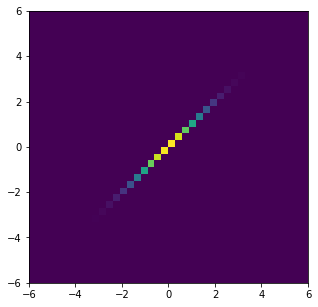

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( mc_pts[:,i], mc_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

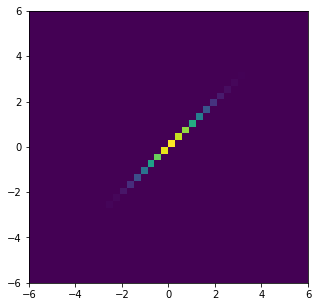

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

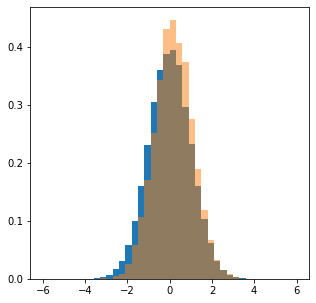

In [20]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( mc_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [21]:
mc_pts_minus_mc_mu = mc_pts - mc_mu
print(mc_pts_minus_mc_mu)

[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 ...
 [ 0.08122531]
 [ 0.34404618]
 [-0.74755625]]


In [22]:
mc_pts_minus_true_mu = mc_pts - true_mu
print(mc_pts_minus_true_mu)

[[ 1.42434536]
 [-0.81175641]
 [-0.72817175]
 ...
 [-0.11877469]
 [ 0.14404618]
 [-0.94755625]]


In [23]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, mc_pts_minus_true_mu.T, axes=(1,0) )

In [24]:
v_times_true_cov_inv_times_v =  np.sum( mc_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [25]:
mc_cov_inv_times_v = np.tensordot( mc_cov_inv, mc_pts_minus_mc_mu.T, axes=(1,0) )

In [26]:
v_times_mc_cov_inv_times_v =  np.sum( mc_pts_minus_mc_mu.T * mc_cov_inv_times_v, axis=0)

In [27]:
exp_v_times_mc_cov_inv_times_v = np.exp( -0.5 * v_times_mc_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [28]:
true_cov_det = np.linalg.det( true_cov )
mc_cov_det = np.linalg.det( mc_cov )

In [29]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [30]:
norm2_mc = np.power( 3.14159265, ndim) * mc_cov_det
print("\n norm2_mc : %f\n" % norm2_mc )


 norm2_mc : 3.141593



In [31]:
pdf_mc = exp_v_times_mc_cov_inv_times_v / np.sqrt(norm2_mc)
print(pdf_mc)

[0.15082819 0.46790598 0.49073665 ... 0.56233152 0.53176755 0.42665263]


In [32]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.17918702 0.4173781  0.45189319 ... 0.62144199 0.61889934 0.36014781]


In [33]:
pdf_ratio = pdf_true / pdf_mc

In [34]:
sample_sf = (1.*len(true_pts))/(1.*len(mc_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [35]:
calc_weight = pdf_ratio

In [36]:
calc_weight_scaled = sample_sf * pdf_ratio

In [37]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [38]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [39]:
weights_true = np.ones( ngen_true )

In [40]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [41]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [42]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.191
  cov f0f0 :   0.8066
  sigma f0 :   0.8981


In [43]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [44]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [45]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.191
  cov f0f0 :   0.8066
  sigma f0 :   0.8981


In [46]:
test_calc_true_model

{'mean': array([0.19097402]), 'cov': array([[0.80655363]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [47]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [48]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, mc_mu, true_cov, mc_cov, mc_pts )

In [49]:
test_calc_pdf_ratio

array([1.18802069, 0.89201275, 0.92084663, ..., 1.10511677, 1.16385316,
       0.8441242 ])

In [50]:
pdf_ratio

array([1.18802069, 0.89201275, 0.92084663, ..., 1.10511677, 1.16385316,
       0.8441242 ])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [51]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [52]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [53]:
weights_true = np.ones( ngen_true )
weights_mc = np.ones( ngen_mc )

print(' mc_pts shape: %s' % str(mc_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_mc shape: %s' % str(weights_mc.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( mc_pts, true_pts, weights_mc, weights_true, hist_pars )

 mc_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_mc shape: (100000,)
  weights_true shape: (10000,)


In [54]:
pdf_ratio

array([1.18802069, 0.89201275, 0.92084663, ..., 1.10511677, 1.16385316,
       0.8441242 ])

In [55]:
calc_weight

array([1.18802069, 0.89201275, 0.92084663, ..., 1.10511677, 1.16385316,
       0.8441242 ])

In [56]:
test_hist_pdf_ratio

array([1.07566089, 0.87327741, 0.91577733, ..., 1.08097928, 1.09625314,
       0.85320793])

In [57]:
test_hist_pdf_ratio.shape

(100000,)

In [58]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, mc_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x   1.624   true   1.1880  from hist  1.0757
   1   x  -0.612   true   0.8920  from hist  0.8733
   2   x  -0.528   true   0.9208  from hist  0.9158
   3   x  -1.073   true   0.7267  from hist  0.7395
   4   x   0.865   true   1.2294  from hist  1.2205
   5   x  -2.302   true   0.3299  from hist  0.2772
   6   x   1.745   true   1.1670  from hist  1.1400
   7   x  -0.761   true   0.8393  from hist  0.8237
   8   x   0.319   true   1.1589  from hist  1.1421
   9   x  -0.249   true   1.0119  from hist  1.0782
  10   x   1.462   true   1.2104  from hist  1.1949
  11   x  -2.060   true   0.3962  from hist  0.3226
  12   x  -0.322   true   0.9889  from hist  1.0091
  13   x  -0.384   true   0.9690  from hist  0.9701
  14   x   1.134   true   1.2335  from hist  1.2396
  15   x  -1.100   true   0.7169  from hist  0.7616
  16   x  -0.172   true   1.0352  from hist  1.1130
  17   x  -0.878   true   0.7973  from hist  0.7748
  18   x   0.042   true   1.0951  from hist  1.0618
  19   x   0

## Define OmniFold implementation

In [59]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_mc = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_mc = ngen_mc
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_mc : %d" % neval_mc )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_mc)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_mc) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )



        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
     

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [60]:
of_return_dict = hist_pdf_omnifold1a( mc_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_mc : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.07468124 0.87314662 0.91577733 ... 1.08084359 1.09743182 0.85335125]
  iter 1, step1_output_weights:  shape (100000,)
[1.07468124 0.87314662 0.91577733 ... 1.08084359 1.09743182 0.85335125]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[1.11154729 0.86740316 0.89956526 ... 1.09615903 1.13155725 0.82636823]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.11154729 0.86740316 0.89956526 ... 1.09615903 1.13155725 0.82636823]
 pdf_ratio_step1:  shape (100000,) 
[0.95699547 1.00584355 1.0195217  ... 0.97813745 0.96034643 1.0344829 ]
  iter 2, step1_

In [61]:
of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(mc_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

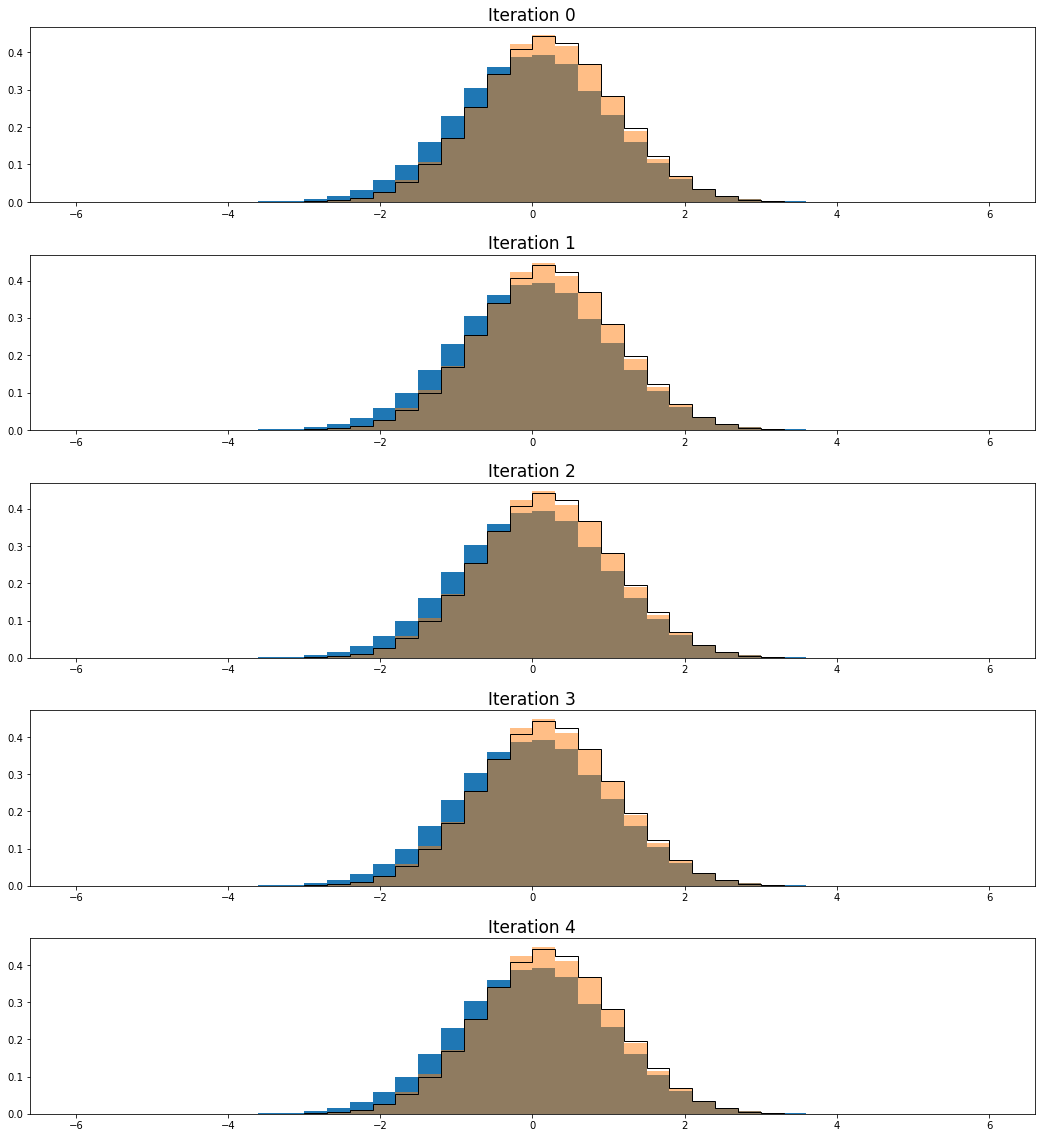

In [62]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [63]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

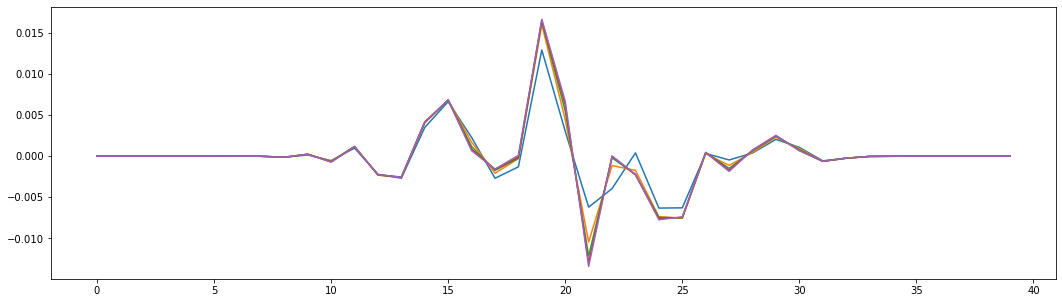

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

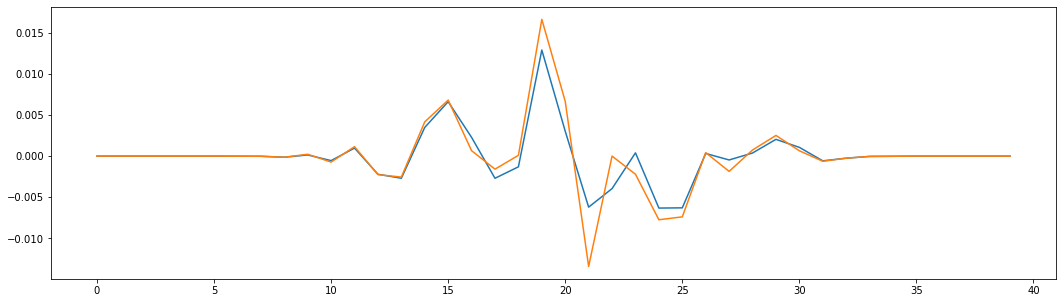

In [65]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

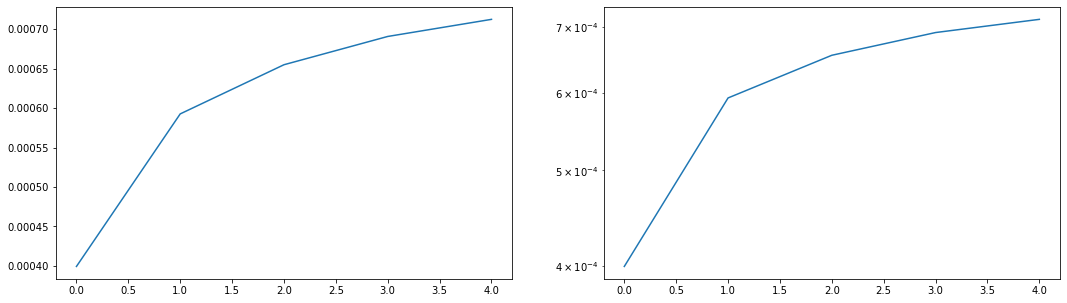

In [66]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

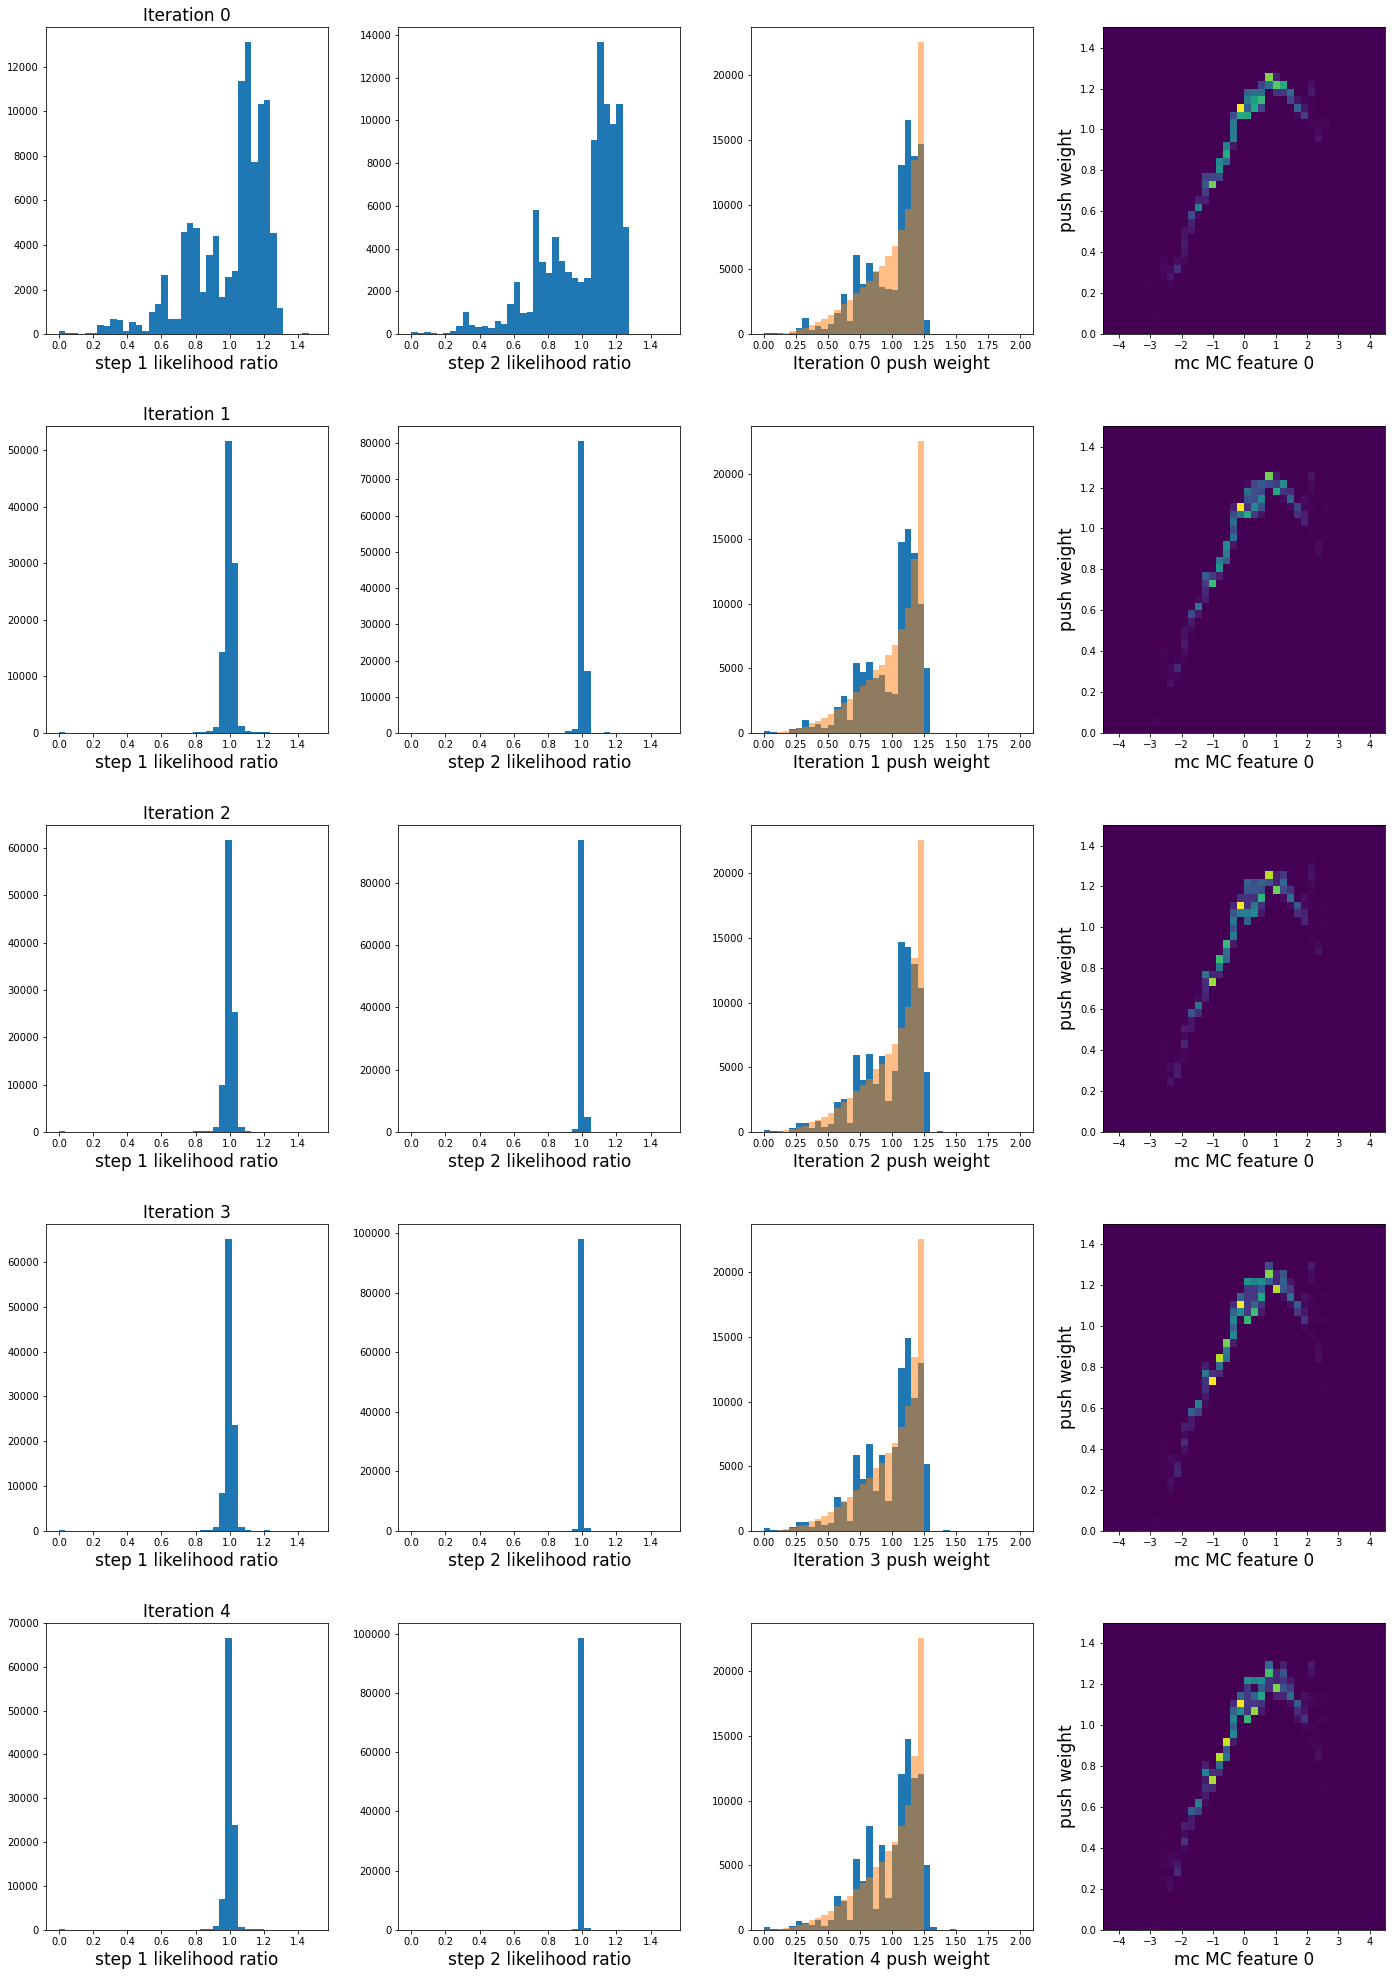

In [67]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ###ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][3].hist2d( mc_pts[:,0], push_weights[ofi,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
    
    
    
    
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ###ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ###ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )

    ax[ofi][3].set_xlabel( 'mc MC feature 0' , fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'push weight' , fontsize=lfontsize )
    
    
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

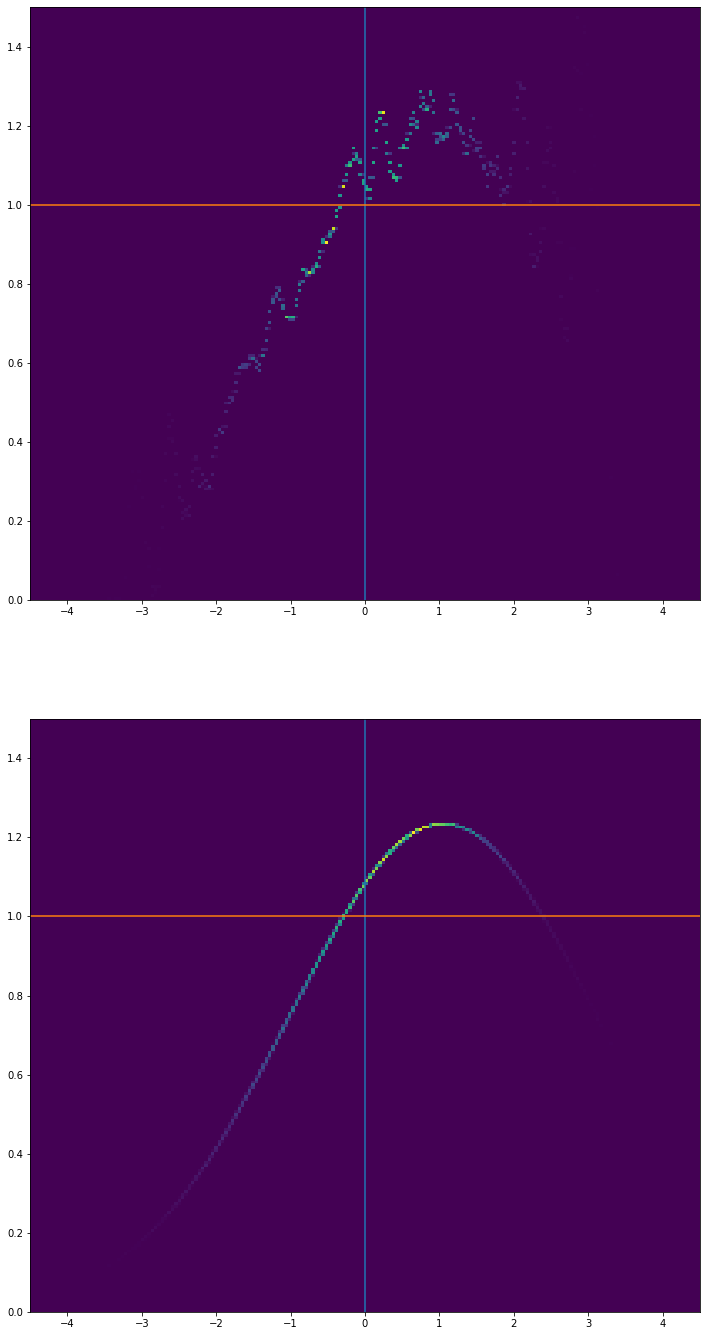

In [68]:
fig,ax = plt.subplots( 2, 1, figsize=(12,2*12))

hbins=200

hpw,_,_,_ = ax[0].hist2d( mc_pts[:,0], push_weights[-1,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

hcw,_,_,_ = ax[1].hist2d( mc_pts[:,0], calc_weight, 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

ax[0].plot([0,0],[0,1.5])
ax[0].plot([-4.5,4.5],[1,1])

ax[1].plot([0,0],[0,1.5])
ax[1].plot([-4.5,4.5],[1,1])

plt.show

In [69]:
fpw = np.zeros( hpw.shape[0])

for bi0 in range(hpw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hpw.shape[1]) :
        esum += hpw[bi0,bi1]
        biesum += bi1*hpw[bi0,bi1]
        #print(' %3d, %3d :  %8.0f    %8.0f  %8.0f' % (bi0, bi1, hpw[bi1,bi0], esum, biesum))
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fpw[bi0] = wave
    #print(' %3d : %8.3f' % (bi0, wave))

In [70]:
fcw = np.zeros( hcw.shape[0])

for bi0 in range(hcw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hcw.shape[1]) :
        esum += hcw[bi0,bi1]
        biesum += bi1*hcw[bi0,bi1]
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fcw[bi0] = wave


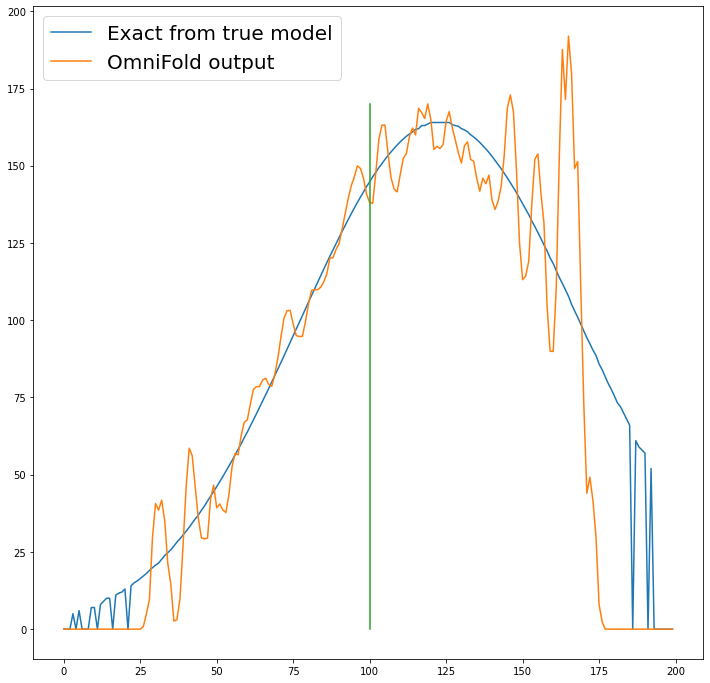

In [71]:
fig,ax = plt.subplots( 1, 1, figsize=(12,12))
ax.plot(fcw, label='Exact from true model')
ax.plot(fpw, label='OmniFold output')
ax.plot([100,100],[0,170])
ax.legend( fontsize=20 )

#plt.savefig('of-final-weight-function-hist-pdf.pdf', bbox_inches='tight')     

<function matplotlib.pyplot.show(close=None, block=None)>

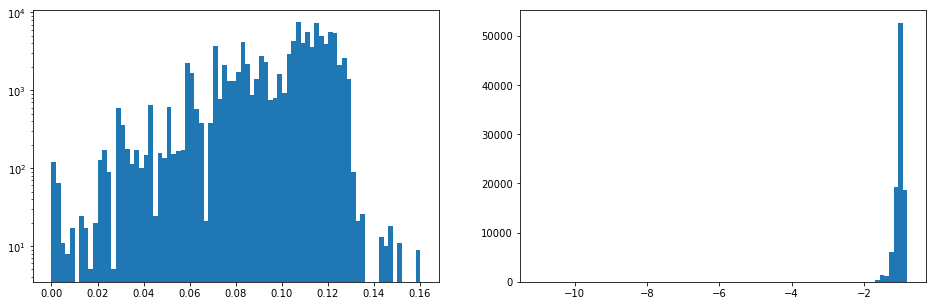

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

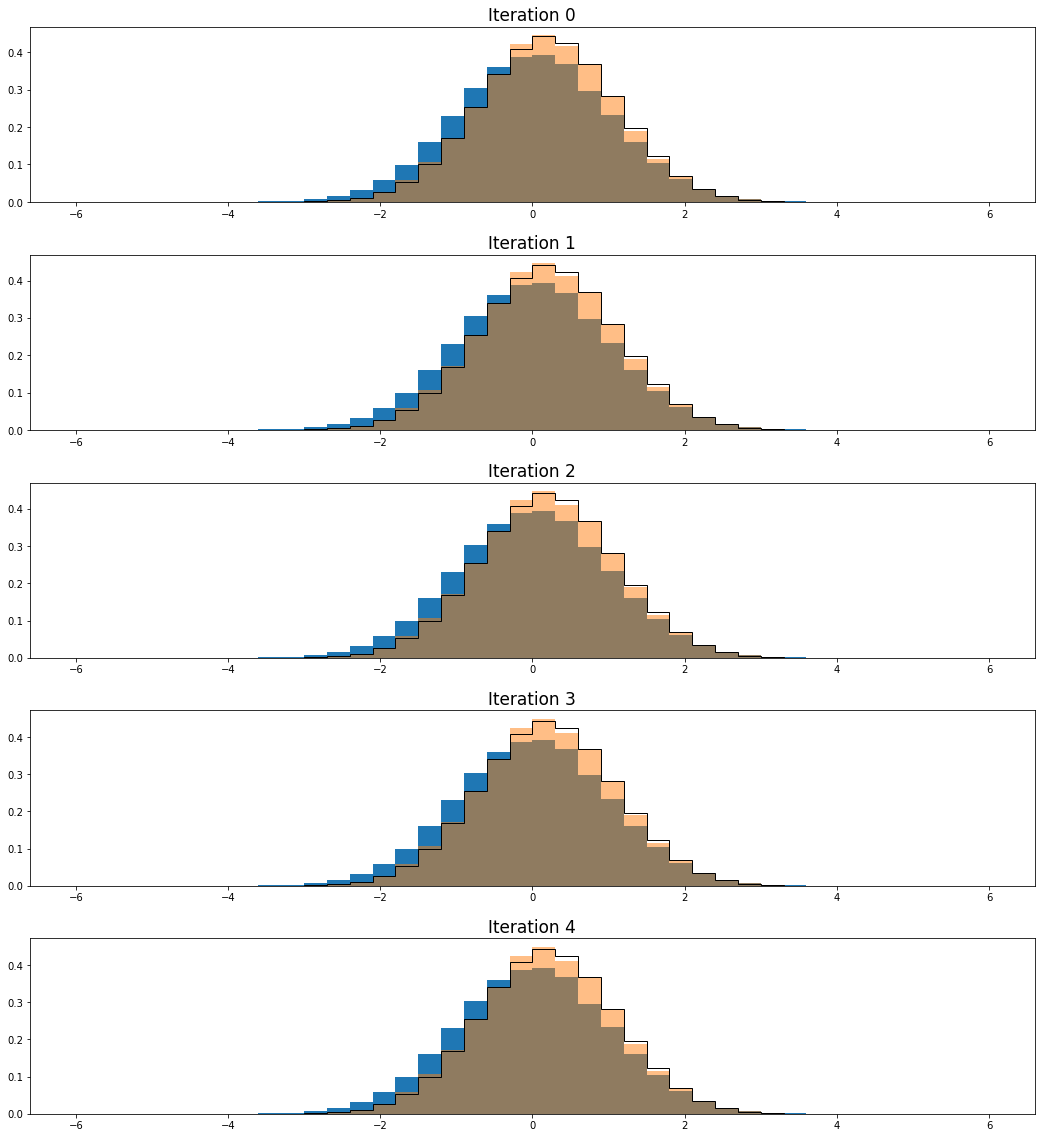

In [73]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [74]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

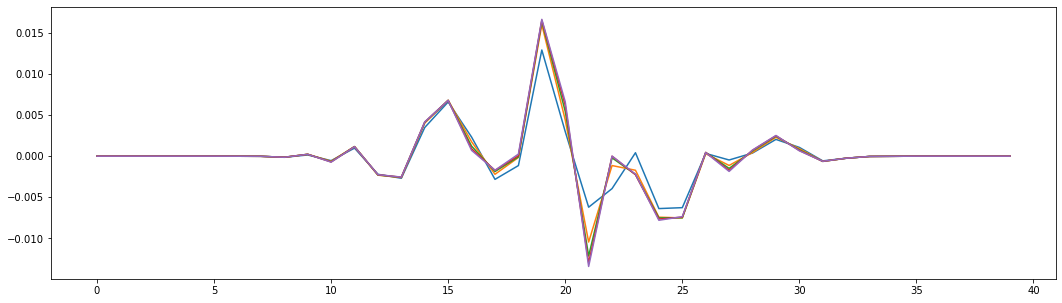

In [75]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

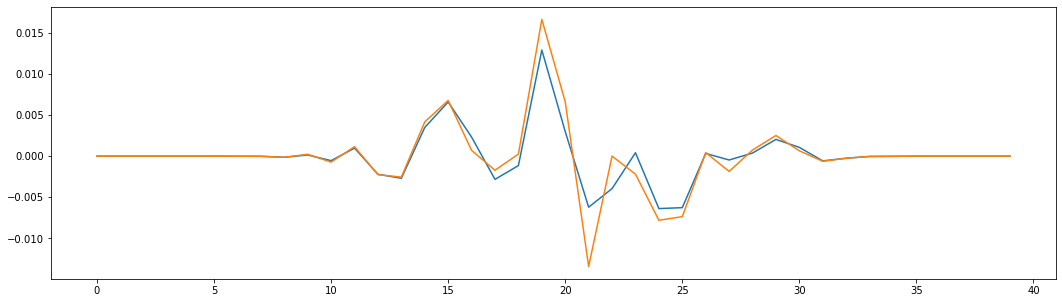

In [76]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

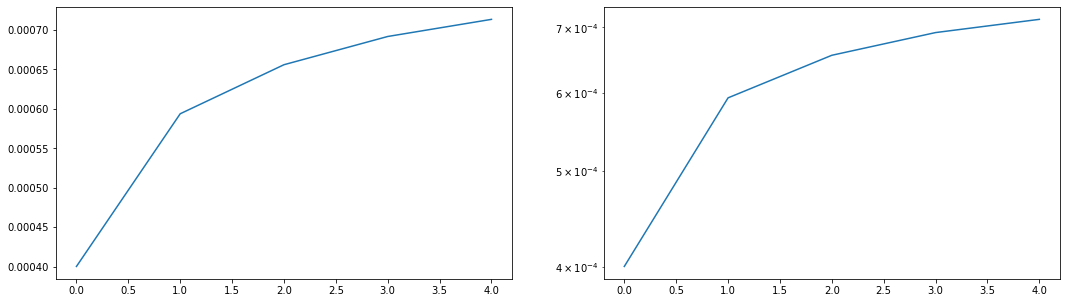

In [77]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [78]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.998  rms 0.226      step 2 mean  0.998  rms 0.224
  iter  1 : step 1 mean  0.999  rms 0.046      step 2 mean  1.000  rms 0.026
  iter  2 : step 1 mean  0.999  rms 0.041      step 2 mean  0.999  rms 0.020
  iter  3 : step 1 mean  0.999  rms 0.040      step 2 mean  0.999  rms 0.018
  iter  4 : step 1 mean  0.999  rms 0.040      step 2 mean  1.000  rms 0.017


<function matplotlib.pyplot.show(close=None, block=None)>

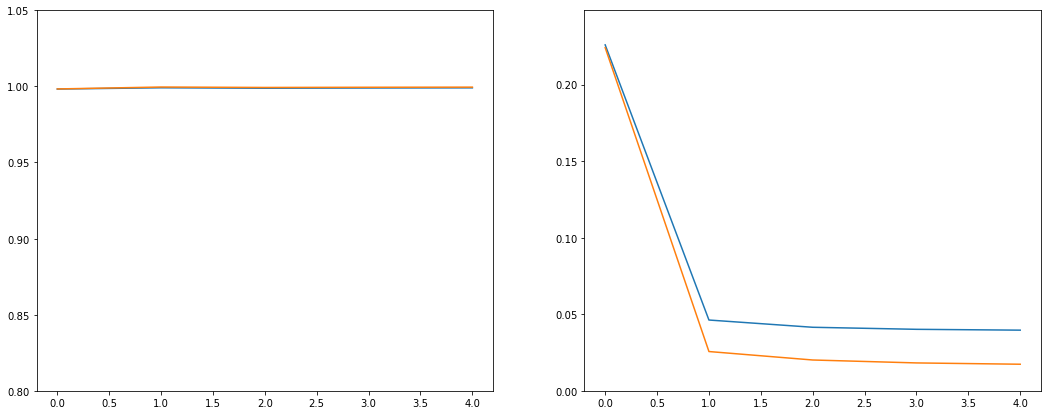

In [79]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

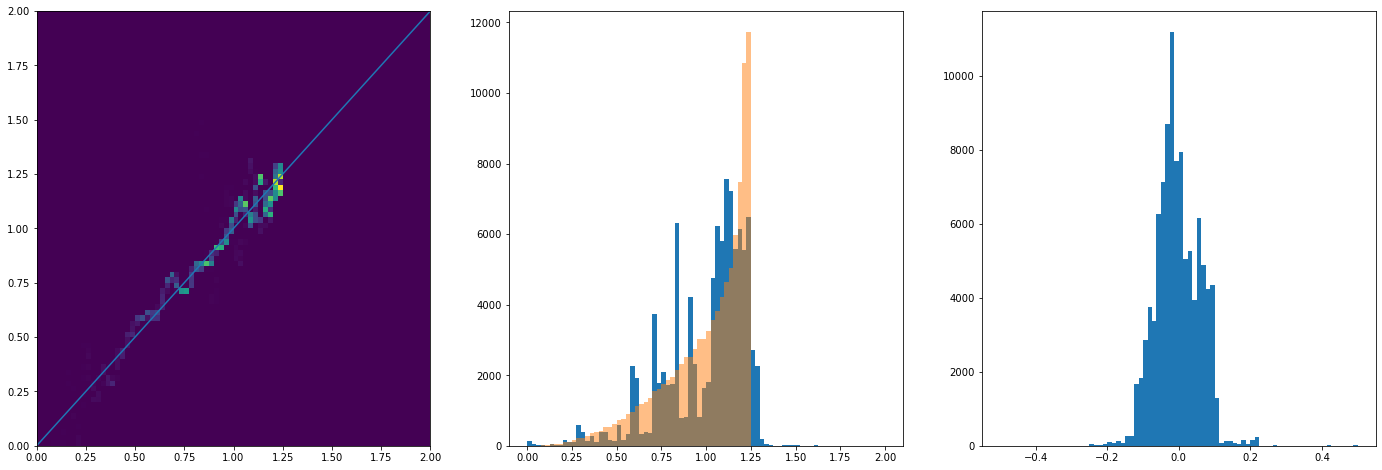

In [80]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [81]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.06318




In [82]:
of_prob = of_return_dict['weights'] / (1. + of_return_dict['weights'] )

In [83]:
def profile2d( axis, xvals, yvals, hbins, hrange, drawhist=True, drawline=False ) :
    
    hist_data = axis.hist2d( xvals, yvals, bins=hbins, range=hrange)
    
    if not drawhist :
        axis.cla()

    nybins = len(hist_data[0][0])
    print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins ) :  
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, fmt='-', linewidth=5)

    
    plt.show
    

In [84]:
def prob_from_hists( points_a, points_b, weights_a, weights_b, hnbins, hxmin, hxmax ) :
    
    hbw = (hxmax-hxmin)/hnbins
    
    #-- calculate bin indices
    bin_indices_a = np.array( (points_a - hxmin)/hbw, dtype=int )
    bin_indices_b = np.array( (points_b - hxmin)/hbw, dtype=int )
    
    
    hist_binsum_a = np.zeros( hnbins )
    hist_binsum_b = np.zeros( hnbins )
    
    hist_err_a = np.zeros( hnbins )
    hist_err_b = np.zeros( hnbins )
    
    hist_ratio = np.zeros( hnbins )
    hist_ratio_err = np.zeros( hnbins )
    
    sample_wsum_a = np.sum(weights_a)
    sample_wsum_b = np.sum(weights_b)

    
    for bi in range( hnbins ) :
        hist_binsum_a[bi] = np.sum( weights_a[ bin_indices_a == bi ] ) / sample_wsum_a
        hist_binsum_b[bi] = np.sum( weights_b[ bin_indices_b == bi ] ) / sample_wsum_b
        hist_err_a[bi] = np.sqrt( np.sum( np.square( weights_a[ bin_indices_a == bi ] ) ) ) / sample_wsum_a
        hist_err_b[bi] = np.sqrt( np.sum( np.square( weights_b[ bin_indices_b == bi ] ) ) ) / sample_wsum_b
        if hist_binsum_b[bi] > 0 :
            hist_ratio[bi] = hist_binsum_b[bi] / (hist_binsum_a[bi] + hist_binsum_b[bi])
            if hist_binsum_a[bi] > 0 :
                hist_ratio_err[bi] = np.sqrt(
                    np.square( (hist_binsum_b[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_a[bi] ) +
                    np.square( (hist_binsum_a[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_b[bi] )
                )
        
    return_dict = {}
    return_dict['hist_binsum_a'] = hist_binsum_a
    return_dict['hist_binsum_b'] = hist_binsum_b
    return_dict['hist_err_a'] = hist_err_a
    return_dict['hist_err_b'] = hist_err_b
    return_dict['hist_ratio'] = hist_ratio
    return_dict['hist_ratio_err'] = hist_ratio_err
    
    return return_dict
    

number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

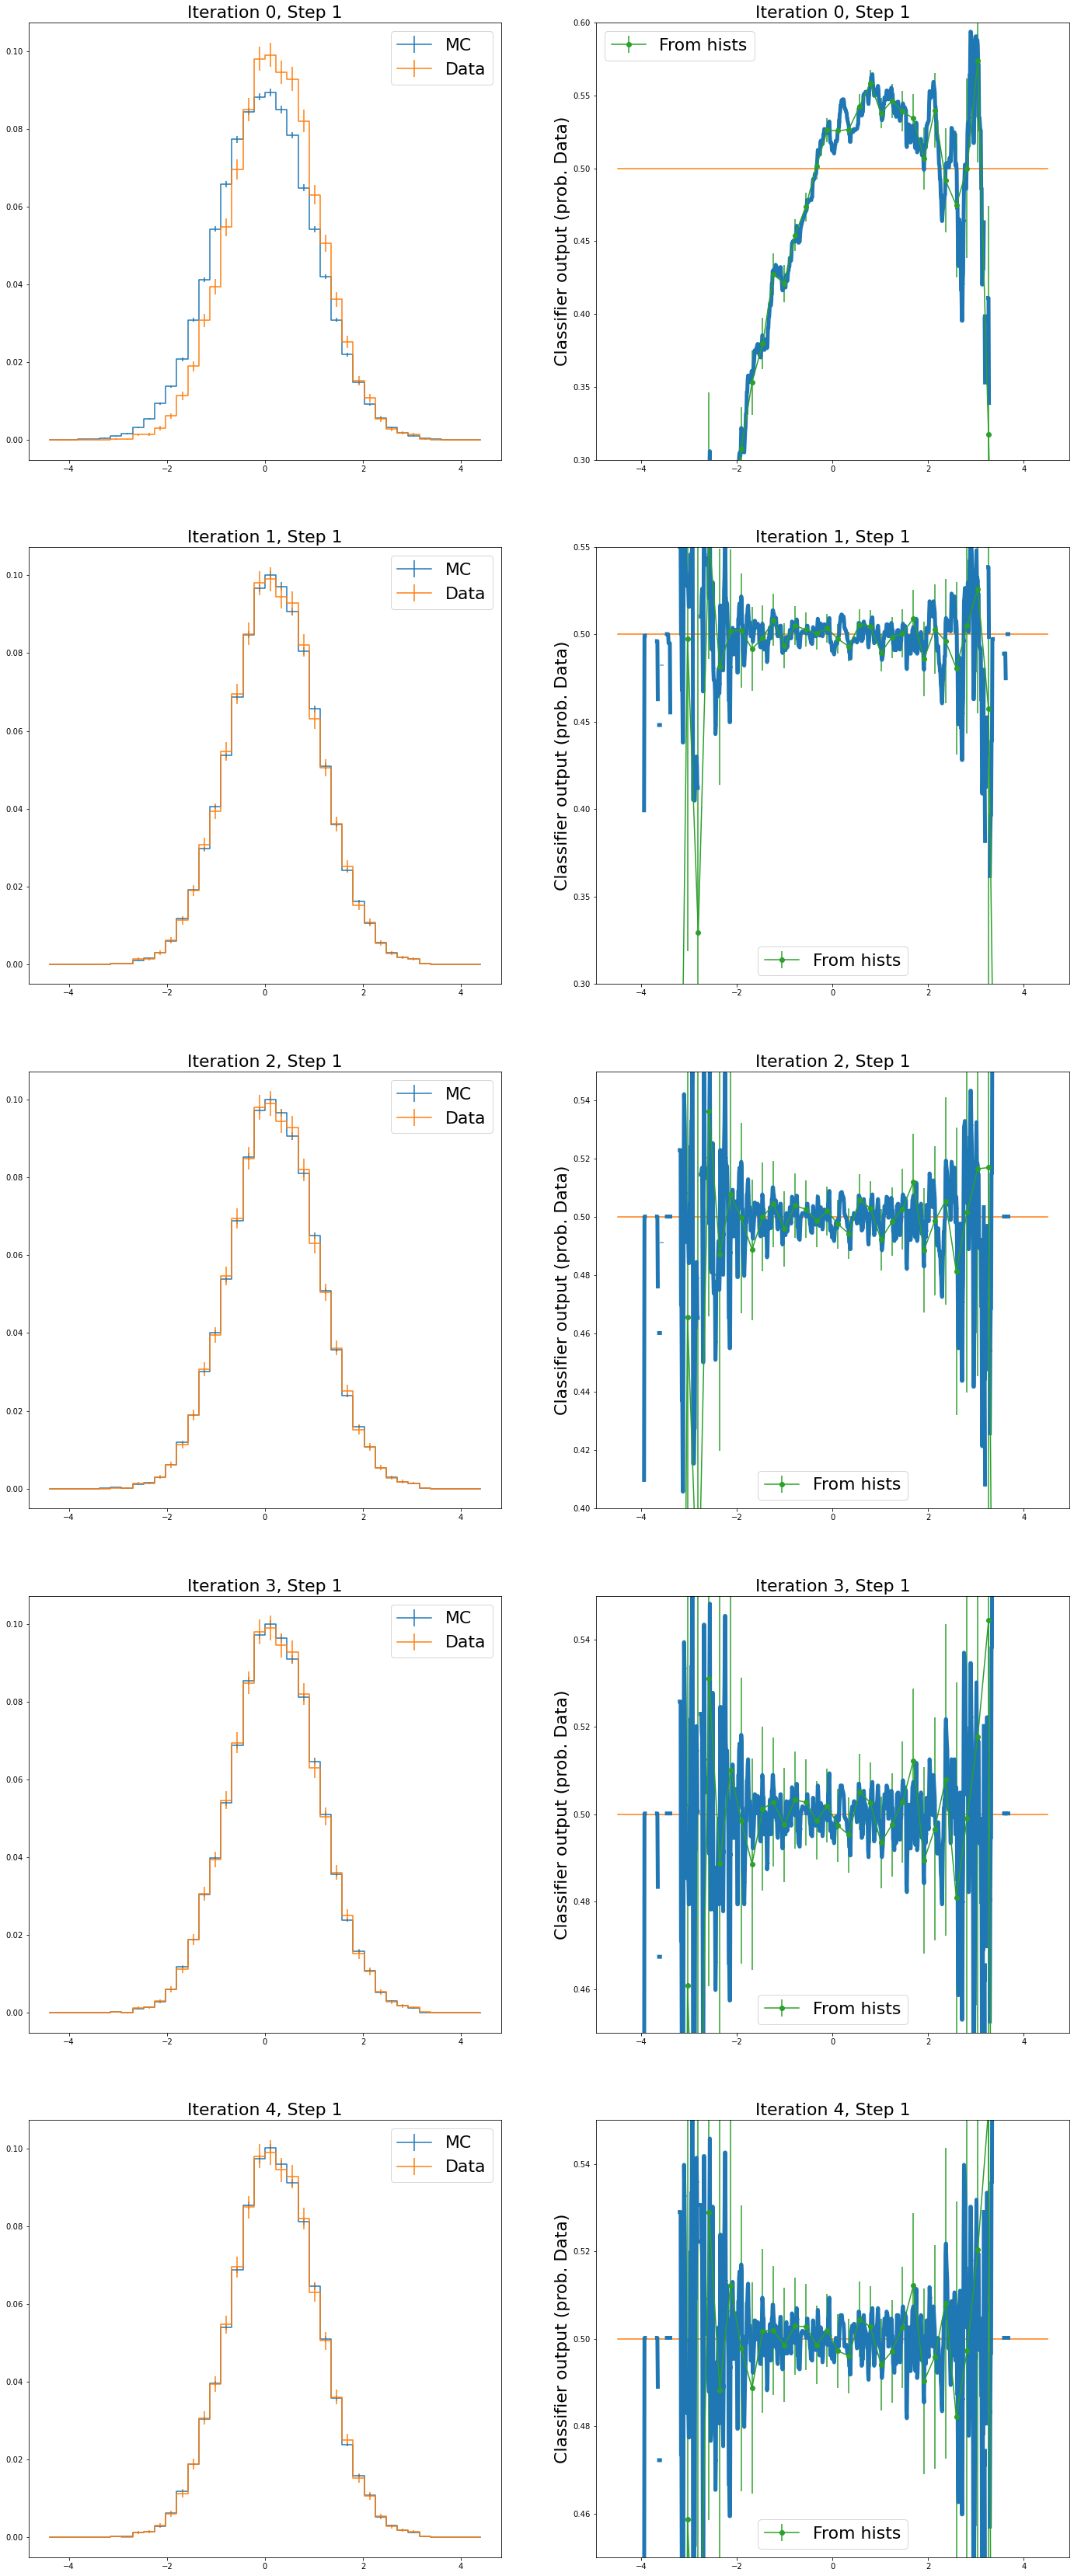

In [85]:

hxmin = -4.5
hxmax = 4.5


hnbins = 40

ymin = 0.2
ymax = 0.6

hbw = (hxmax-hxmin) / hnbins

xvals = np.zeros( hnbins )
for bi in range( hnbins ) :
    xvals[bi] = hxmin + (0.5 + bi)*hbw

nnbins = 1000

plotymin=[0.30, 0.30, 0.40, 0.45, 0.45]
plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]


#plotymin=[0.30, 0.45, 0.49, 0.49, 0.49]
#plotymax=[0.60, 0.55, 0.51, 0.51, 0.51]



fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


for ofi in range( of_niter ) :
    
    weights_ones_b = np.ones( len(true_det_pts[:,0]) )

    if ofi==0 :        
        weights_a = np.ones( len(mc_det_pts[:,0]) )        
    else :
        weights_a = of_return_dict['push_weights'][ofi-1]

    rd = prob_from_hists( mc_det_pts[:,0], 
                             true_det_pts[:,0], 
                             weights_a, 
                             weights_ones_b, 
                             hnbins, hxmin, hxmax )

    axi = ax[ofi][0]
    axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
    axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='Data')
    axi.legend( fontsize=22 )
    axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )
        
    axi = ax[ofi][1]
    profile2d( axi, mc_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[nnbins,nnbins], hrange=([hxmin,hxmax],[ymin,ymax]), drawhist=False, drawline=False ) 
    axi.plot([hxmin,hxmax],[0.5,0.5])
    axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
    axi.legend( fontsize=22 )
    axi.set_ylabel('Classifier output (prob. Data)', fontsize=22 )
    
    axi.set_ylim( plotymin[ofi], plotymax[ofi] )
    axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )
        

#plt.savefig('of-monitor-step1-hist-pdf.pdf', bbox_inches='tight')         
        
plt.show

number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_2237750/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2237750/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

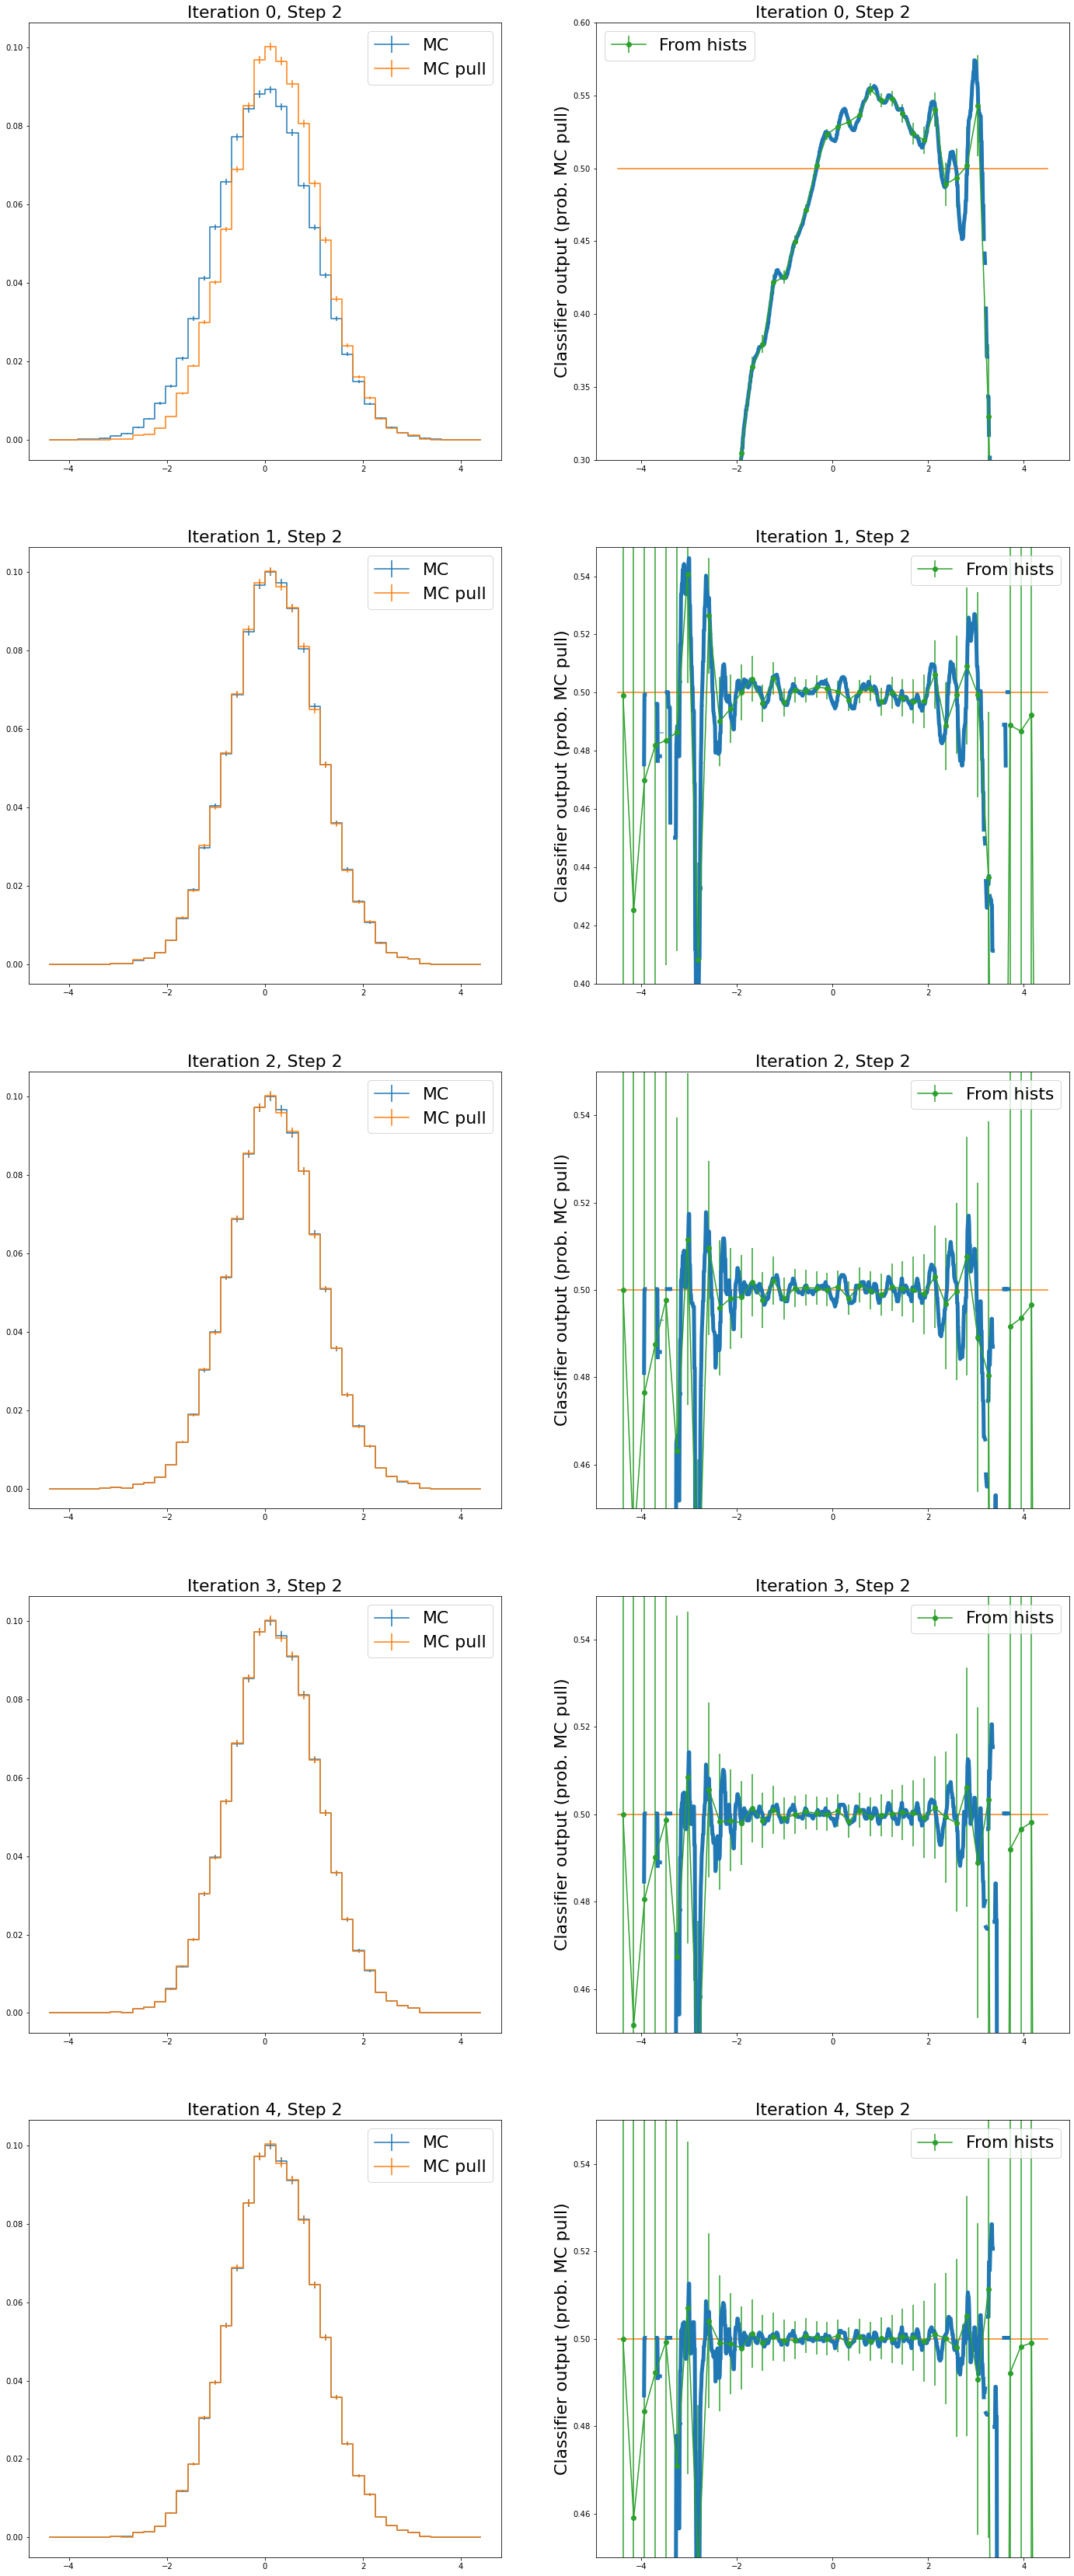

In [86]:

hxmin = -4.5
hxmax = 4.5


hnbins = 40



hbw = (hxmax-hxmin) / hnbins

xvals = np.zeros( hnbins )
for bi in range( hnbins ) :
    xvals[bi] = hxmin + (0.5 + bi)*hbw

nnbins = 1000

plotymin=[0.30, 0.40, 0.45, 0.45, 0.45]
plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]

#plotymin=[0.30, 0.45, 0.49, 0.49, 0.49]
#plotymax=[0.60, 0.55, 0.51, 0.51, 0.51]





fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


for ofi in range( of_niter ) :
    
    previous_push_weights = np.ones( len(mc_pts[:,0]))
    if ofi > 0 :
        previous_push_weights = of_return_dict['push_weights'][ofi-1]
                
    pull_weights = previous_push_weights * of_return_dict['weights'][ofi,0,:]
    


    rd = prob_from_hists( mc_pts[:,0], 
                             mc_pts[:,0], 
                             previous_push_weights, 
                             pull_weights, 
                             hnbins, hxmin, hxmax )

    axi = ax[ofi][0]
    axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
    axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='MC pull')
    axi.legend( fontsize=22 )
    axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )
        
    axi = ax[ofi][1]
    profile2d( axi, mc_pts[:,0], of_prob[ofi,1,:], 
          hbins=[nnbins,nnbins], hrange=([hxmin,hxmax],[ymin,ymax]), drawhist=False, drawline=False ) 
    axi.plot([hxmin,hxmax],[0.5,0.5])
    axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
    axi.legend( fontsize=22 )
    axi.set_ylabel('Classifier output (prob. MC pull)', fontsize=22 )
    
    axi.set_ylim( plotymin[ofi], plotymax[ofi] )
    axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )
        

#plt.savefig('of-monitor-step2-hist-pdf.pdf', bbox_inches='tight')           
        
plt.show

In [87]:

verbose = False



import gc

In [88]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    this_random_seed = random_seed*10000+bi
    
    np.random.seed( this_random_seed )
    

    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        

    
    rd = hist_pdf_omnifold1a( mc_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(mc_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0,  this_ngen_true = 10013
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.14475898 0.91082809 0.96067847 ... 1.1025059  1.15175794 0.80555289]
 weights_push at the beginning
[1.1334894  0.92669573 0.98239201 ... 1.10393584 1.15780251 0.79688888]
 weights_push at the beginning
[1.12618106 0.93409328 0.99267641 ... 1.10354273 1.16324711 0.79229974]
 weights_push at the beginning
[1.11885399 0.93834398 0.99958109 ... 1.10230768 1.16757925 0.79025273]


 bootstrap 0 final push weights scaled:
[0.11144978 0.09420962 0.10063428 ... 0.11019746 0.11724492 0.07901706]

 Creating toy sample   1,  this_ngen_true = 10098
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10143713 0.89203212 0.93463129 ... 1.08610854 1.20285892 0.79851639]
 weights_push at the beginning
[1.09151642 0.90214976 0.9469954  ... 1.0864659  1.22108774 0.78389251]
 weights_push at the beginning
[1.09952396 0.90693542 0.


 Creating toy sample  13,  this_ngen_true = 10046
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.26898911 0.87144025 0.88688212 ... 1.06274789 1.13744888 0.84524593]
 weights_push at the beginning
[1.27859638 0.87073112 0.88322304 ... 1.05730375 1.14243001 0.84480429]
 weights_push at the beginning
[1.28111991 0.87104682 0.88116351 ... 1.05496174 1.14426054 0.8447168 ]
 weights_push at the beginning
[1.28345746 0.87135713 0.87956785 ... 1.05426677 1.14436796 0.84522641]


 bootstrap 13 final push weights scaled:
[0.12926484 0.08754163 0.08821713 ... 0.10590131 0.11489119 0.0849733 ]

 Creating toy sample  14,  this_ngen_true = 10057
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.29223965 0.84120214 0.88746978 ... 1.07203792 1.18897744 0.79228328]
 weights_push at the beginning
[1.30282203 0.84244096 0.89732247 ... 1.07534716 1.19569371 0.78573887]
 weights_push at the beginning
[1.30949601 0.84497109 0


 Creating toy sample  26,  this_ngen_true = 10068
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.00640884 0.91128967 0.92958812 ... 1.11058998 1.17680127 0.90761088]
 weights_push at the beginning
[0.95449125 0.90588215 0.92766848 ... 1.11568028 1.17098654 0.9178041 ]
 weights_push at the beginning
[0.9399803  0.90241843 0.92580463 ... 1.11317303 1.16399057 0.92249863]
 weights_push at the beginning
[0.93593235 0.90112609 0.9238446  ... 1.11003652 1.15915086 0.92742636]


 bootstrap 26 final push weights scaled:
[0.09420312 0.0906909  0.09276869 ... 0.11149544 0.11635715 0.09389397]

 Creating toy sample  27,  this_ngen_true = 9940
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.22503043 0.86854601 0.9197724  ... 1.09174454 1.19441658 0.86545129]
 weights_push at the beginning
[1.25639624 0.85444148 0.92511499 ... 1.0889286  1.19862019 0.87600173]
 weights_push at the beginning
[1.27585864 0.84433569 0.

 weights_push at the beginning
[1.22865911 0.89327145 0.89011675 ... 1.08042014 1.12612337 0.90224336]


 bootstrap 39 final push weights scaled:
[0.1221912  0.0884741  0.08818922 ... 0.10722059 0.11126538 0.08962539]

 Creating toy sample  40,  this_ngen_true = 10148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16691772 0.84577244 0.89141296 ... 1.09558614 1.18041476 0.86916688]
 weights_push at the beginning
[1.16477522 0.82771198 0.88996716 ... 1.07933927 1.1855183  0.88243304]
 weights_push at the beginning
[1.17213356 0.81829765 0.89344144 ... 1.07054648 1.1858464  0.88576258]
 weights_push at the beginning
[1.18042993 0.81432756 0.89859268 ... 1.06534217 1.1839036  0.88706989]


 bootstrap 40 final push weights scaled:
[0.12062819 0.0825003  0.09168828 ... 0.10773595 0.11988163 0.09011018]

 Creating toy sample  41,  this_ngen_true = 9997
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.13771891 0

In [89]:
print('\n\n Done\n\n')



 Done


